# Setting Configs

In [4]:
checkpoint: str = "yolov6t_coco_edter"  #@param ["yolov6t_coco_edter", "yolov6t_aquarium_edter"]
device: str = "cpu" 

import os, requests, torch, math, cv2
import numpy as np
import PIL
from yolov6.utils.events import LOGGER, load_yaml
from yolov6.layers.common import DetectBackend
from yolov6.data.data_augment import letterbox
from yolov6.utils.nms import non_max_suppression
from yolov6.core.inferer import Inferer
from typing import List, Optional
from yolo_utils import *
model = DetectBackend(f"./weights/{checkpoint}.pt", device=device)
stride = model.stride
if checkpoint == 'yolov6t_coco_edter':
    class_names = load_yaml("./data/coco.yaml")['names']
elif checkpoint == 'yolov6t_coco_edter':
    class_names = load_yaml("./data/aquarium.yaml")['names']

model.model.float()
half = False


Loading checkpoint from ./weights/yolov6t_coco_edter.pt

Fusing model...


# Generating Fractals

In [5]:
from utils import *
x_min, x_max, y_min, y_max = -1.245, -1.2455, -0.313, -0.3135
img, x_min, x_max, y_min, y_max = generate_fractals("Burning_ship", x_min, x_max, y_min, y_max)


# Detection

C:\Users\joyho\AppData\Roaming\Python\Python38\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


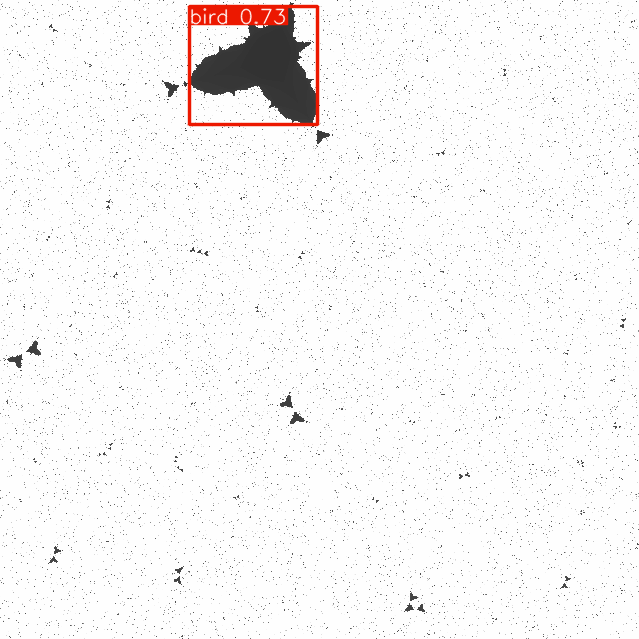

In [6]:

hide_labels: bool = False  #@param {type:"boolean"}
hide_conf: bool = False  #@param {type:"boolean"}

img_size: int = 640  #@param {type:"integer"}

conf_thres: float = .25  #@param {type:"number"}
iou_thres: float = .45  #@param {type:"number"}
max_det: int = 1000  #@param {type:"integer"}
agnostic_nms: bool = False  #@param {type:"boolean"}

img_size = check_img_size(img_size, s=stride)

img, img_src = precess_image(img, img_size, stride, half)
img = img.to(device)
if len(img.shape) == 3:
    img = img[None]
    # expand for batch dim
pred_results = model(img)
classes: Optional[List[int]] = None  # the classes to keep
det = non_max_suppression(pred_results,
                          conf_thres,
                          iou_thres,
                          classes,
                          agnostic_nms,
                          max_det=max_det)[0]

gn = torch.tensor(img_src.shape)[[1, 0, 1, 0]]  # normalization gain whwh
img_ori = img_src.copy()
if len(det):
    det[:, :4] = Inferer.rescale(img.shape[2:], det[:, :4],
                                 img_src.shape).round()
    for *xyxy, conf, cls in reversed(det):
        class_num = int(cls)
        label = None if hide_labels else (
            class_names[class_num]
            if hide_conf else f'{class_names[class_num]} {conf:.2f}')
        Inferer.plot_box_and_label(img_ori,
                                   max(round(sum(img_ori.shape) / 2 * 0.003),
                                       2),
                                   xyxy,
                                   label,
                                   color=Inferer.generate_colors(
                                       class_num, True))
PIL.Image.fromarray(img_ori)